In [1]:
%matplotlib notebook
%matplotlib widget

In [2]:
import os
home = os.getcwd()
os.chdir(home + "/LFM/imaging")


FileNotFoundError: [Errno 2] No such file or directory: '/home/lubo12/LFM/imaging/LFM/imaging'

In [ ]:
import os
os.getcwd()

In [3]:
from reconstruction import reconstruct_vols_from_imgs
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, recording_to_overlay_preview, showvid, get_lenses, array3d_to_video

cmap = "gray"

In [4]:
# pn_psf = r"Y:/hpc/r/lfm2025/psfs"
pn_psfs = r"~/hpc-rw/lfm/psfs"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_psfs, '*'))), reverse=True) if os.path.exists(os.path.join(pn_psfs, rec, 'psf.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250701_1216_PSF_LB_noap_1
20250610_1636_PSF_LB_30k_wo_coverslip_1
20250530_1330_PSF_LB_redFB_1-30K_dim_isolated
20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3


In [5]:
pn_bg = r"~/hpc-rw/lfm/bg"
for file in pathlib.Path(os.path.expanduser(pn_bg)).iterdir():
    if file.is_file():
        print(file.name)

20250602_1753_LB_bg_200s_100laser_2fps.npy
20250701_1651_LB_bg_40fps.h5
20250602_1749_LB_bg_100s.h5
20250602_1749_LB_bg_100s_100laser_2fps.npy
20250611_1508_LB_80fps_100laser_bg.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.h5
20250602_1753_LB_bg_200s.npy
20250602_1749_LB_bg_100s.npy
20250701_1654_LB_bg_2fps.h5
20250611_1508_LB_40fps_100laser_bg.npy
20250701_1649_LB_bg_80fps.h5
20250701_1654_LB_bg_2fps.npy
20250610_1904_80laser_5fps.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.npy
20250602_1753_LB_bg_200s.h5
20250611_1508_LB_40fps_100laser_bg.h5
20250701_1651_LB_bg_40fps.npy
20250611_1508_LB_80fps_100laser_bg.h5
20250701_1649_LB_bg_80fps.npy


In [6]:
# pn_rec = r"Y:/hpc/r/lfm2025/recordings"
pn_rec = r"~/hpc-r/lfm2025/recordings"
includes = ['']
excludes = ["bg"]

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'data.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250701_1638_LB_ZF_v552_f7_40fps_tail
20250701_1636_LB_ZF_v552_f7_80fps_tail
20250701_1633_LB_ZF_v552_f7_80fps_3
20250701_1630_LB_ZF_v552_f7_80fps_2
20250701_1628_LB_ZF_v552_f7_80fps_1
20250701_1625_LB_ZF_v552_f7_40fps_2
20250701_1622_LB_ZF_v552_f7_40fps_1
20250701_1613_LB_ZF_v552_f6_80fps_2
20250701_1610_LB_ZF_v552_f6_80fps_1
20250701_1607_LB_ZF_v552_f6_40fps_2
20250701_1605_LB_ZF_v552_f6_40fps_1
20250701_1602_LB_ZF_v552_f6_40fps_tail2
20250701_1600_LB_ZF_v552_f6_40fps_tail
20250701_1547_LB_ZF_v552_f5_80fps_2
20250701_1544_LB_ZF_v552_f5_80fps_1
20250701_1541_LB_ZF_v552_f5_40fps_2
20250701_1538_LB_ZF_v552_f5_40fps_1
20250701_1522_LB_ZF_v552_f4_80fps_1
20250701_1520_LB_ZF_v552_f4_40fps_2
20250701_1516_LB_ZF_v552_f4_40fps_1
20250701_1503_LB_ZF_v552_f3_80fps_1
20250701_1501_LB_ZF_v552_f3_40fps_2
20250701_1458_LB_ZF_v552_f3_40fps_1
20250701_1444_LB_ZF_v552_f2_80fps_1
20250701_1441_LB_ZF_v552_f2_40fps_3
20250701_1438_LB_ZF_v552_f2_40fps_2
20250701_1435_LB_ZF_v552_f2_40fps_1
20250701_1409_L

In [122]:
import i_o
importlib.reload(i_o)
from i_o import Paths

pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1358_LB_ZF_v552_f1_40fps_2"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

(225, 2048, 2048)


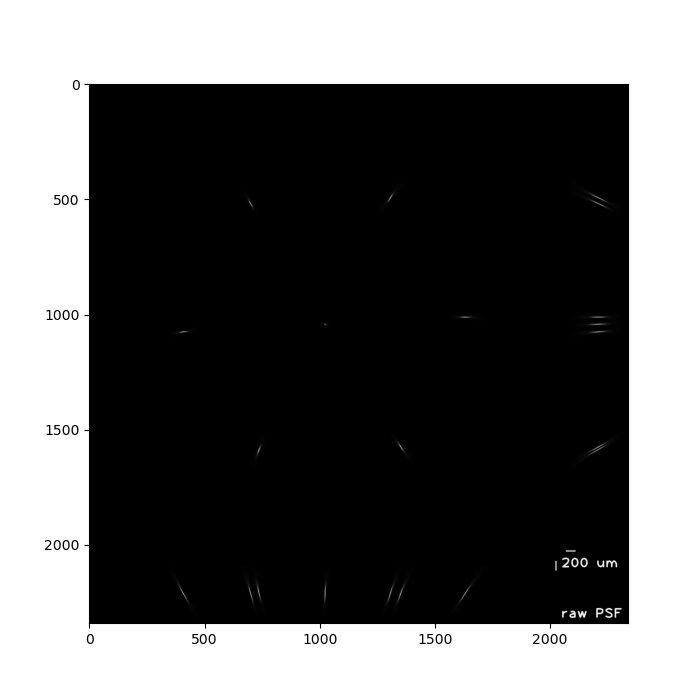

In [10]:
psf_f = lazyh5(paths.psf)
crop = np.array(psf_f["crop"])
mask = np.array(psf_f["circle_mask"][crop[0]:crop[1],crop[2]:crop[3]])
psf = np.array(psf_f["psf"])
zpos=np.array(psf_f["z_positions"])

print(psf.shape)

fig, ax = plt.subplots(1,1,figsize = (7,7))
ax.imshow(create_projection_image(psf, scalebar=200,zpos=zpos, text= "raw PSF", text_size=4), cmap='gray')
# ax[1].imshow(create_projection_image(psf["psf"]-bg,np.max,pad=10), cmap='binary')

In [ ]:
print(og_crop, og_crop[1]-og_crop[0],og_crop[3]-og_crop[2])
better_crop = os.path.expanduser(os.path.join(pn_psfs, "20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1","psf.h5"))
with h5py.File(better_crop,"r") as f:
    crop = list(f["crop"])
    og_mask=np.array(f["circle_mask"])
print(crop, crop[1]-crop[0],crop[3]-crop[2])
plt.imshow(og_mask[crop[0]:crop[1],crop[2]:crop[3]])


In [ ]:
crop[0]=crop[0]-1
crop[2]=crop[2]-1
print(crop, crop[1]-crop[0],crop[3]-crop[2])
mask = og_mask[crop[0]:crop[1],crop[2]:crop[3]]

20250701_1358_LB_ZF_v552_f1_40fps_2


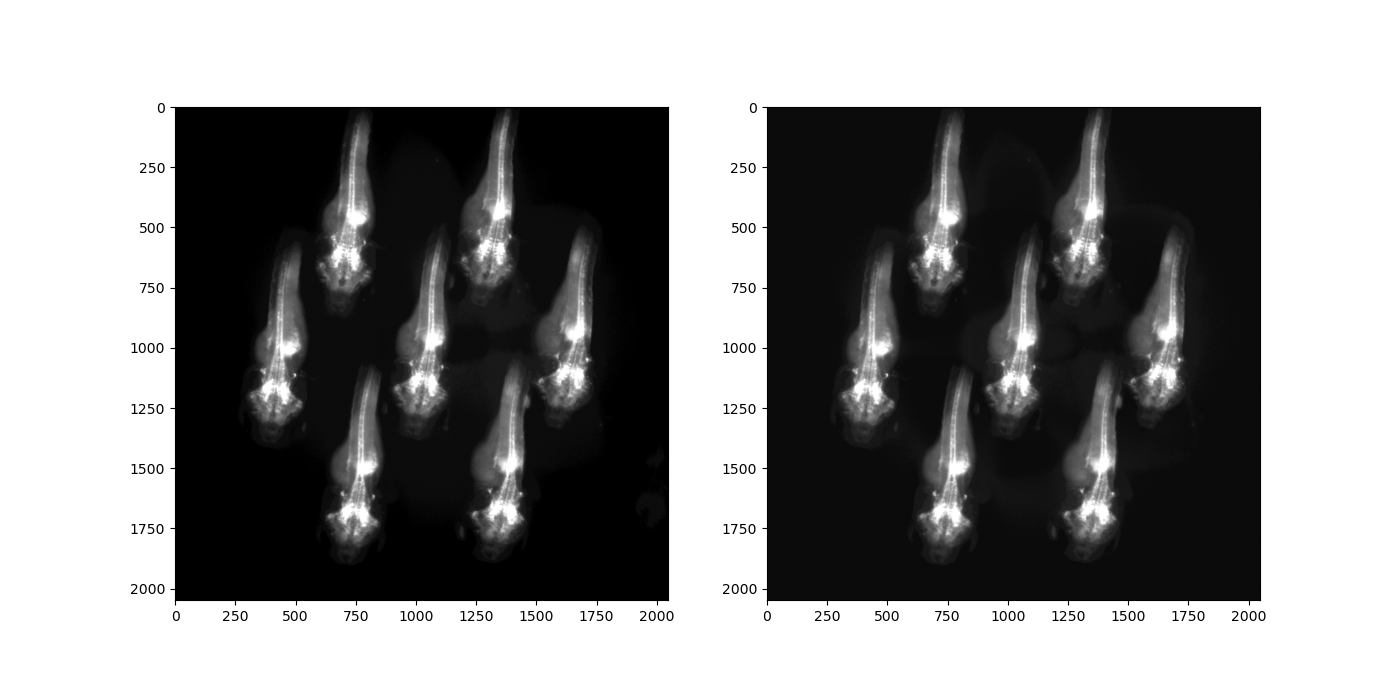

In [123]:
vmax=20


fig, ax = plt.subplots(1,2,figsize = (14,7))
bg = lazyh5(paths.bg)["data"][crop[0]:crop[1],crop[2]:crop[3]]
with h5py.File(paths.raw, "r") as f:
    ims = np.array(f["data"][25:50,crop[0]:crop[1],crop[2]:crop[3]])
im = ims[0]

ax[0].imshow(im, cmap = "gray",vmax=vmax)
ax[1].imshow((im-bg)*mask, cmap="gray",vmax=vmax)
print(dataset_name)

In [ ]:
# cx, cy, radii, masks = get_lenses(og_mask, radius_range=np.arange(525,535))
cx=np.array(psf_f["ml_cx"])
cy=np.array(psf_f["ml_cy"])
radii=np.array(psf_f["ml_radii"])
masks=np.array(psf_f["ml_masks"])

import video
importlib.reload(video)
from video import recording_to_overlay_preview, get_lenses, img_to_overlay_preview, showvid, get_projection_image
fn_vid, fn_file ,fn_dff_vid, fn_dff_file = recording_to_overlay_preview(paths,
                                                      cx,cy,padxy=300,masks=masks, 
                                                      fps=40, 
                                                      avg_method="median", median_avg_window =40, 
                                                      dff=True,
                                                      vmin=0,vmax=100,absolute_limits=False)
showvid(fn_vid)

Loading PSF, Calculating OTF


Calculating OTF: (downsampling PSF by 1):   0%|          | 0/145 [00:00<?, ?it/s]

Reconstructing volumes:   0%|          | 0/1 [00:00<?, ?it/s]

Deconvolving image 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

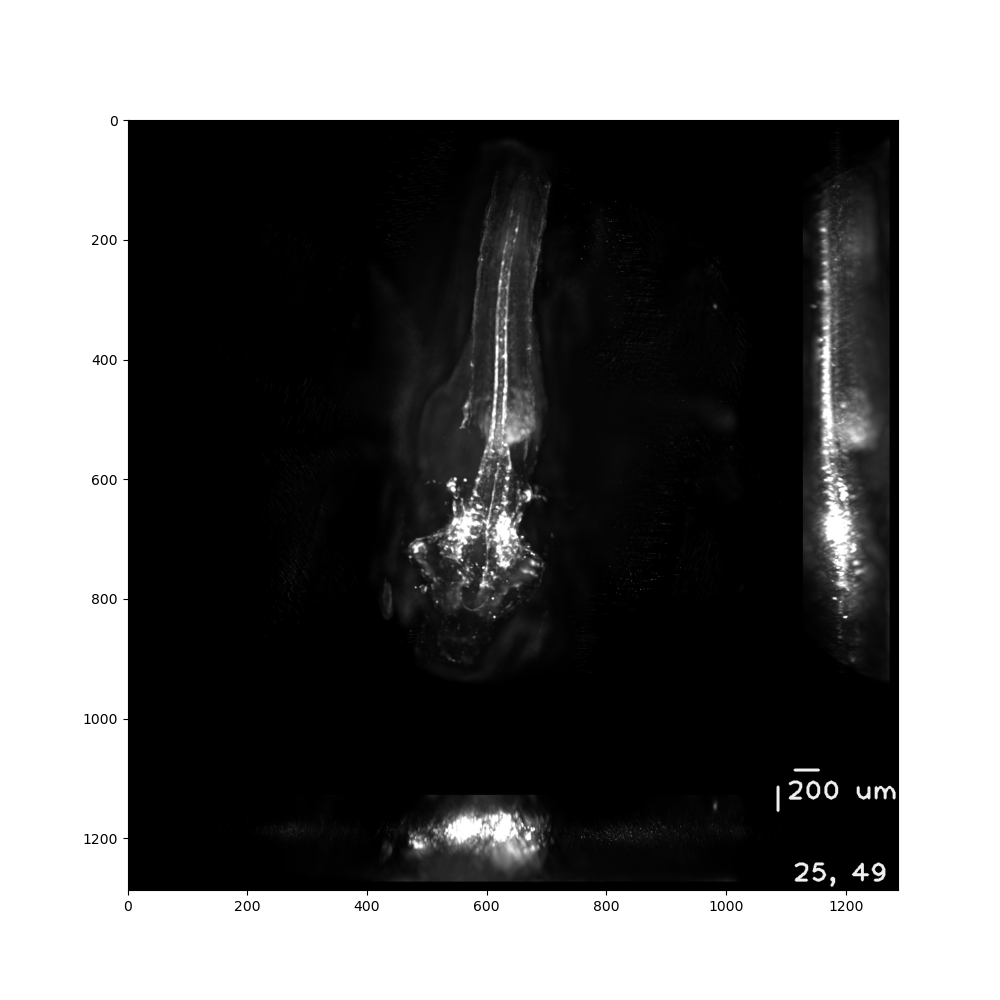

In [127]:
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs
img_idx = [25,26,1]
# print(f"PSF zspacing: {np.abs(np.diff(psf["z_positions"][::2])).mean()*1000} um")
objs, mips, losses, kwargs = reconstruct_vols_from_imgs(paths,
                                                        img_idx=img_idx,
                                                        crop = crop,
                                                        max_iter = 50,
                                                        roi_size=550,
                                                        loss_threshold=0,
                                                        reuse_prev_vol = False,
                                                        psf_downsample = [60,-20,1],
                                                        OTF_normalize=True,
                                                        OTF_clip=False,
                                                        img_subtract_bg=False,
                                                        img_mask=True,
                                                        plot_decon=True,
                                                        fully_batched=False,
                                                        vmin=0,
                                                        vmax=5,
                                                        absolute_limits=True
                                                        )
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(mips[0,-1,:,:],cmap="gray")

Creating video:   0%|          | 0/100 [00:00<?, ?it/s]

'/home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/testmip/deconv_f25_roi500_img_masked_vmin0_vmax5_al_OTF_20250701_1216_PSF_LB_noap_1_pad201_norm_dwn[60, -30, 1].mp4'

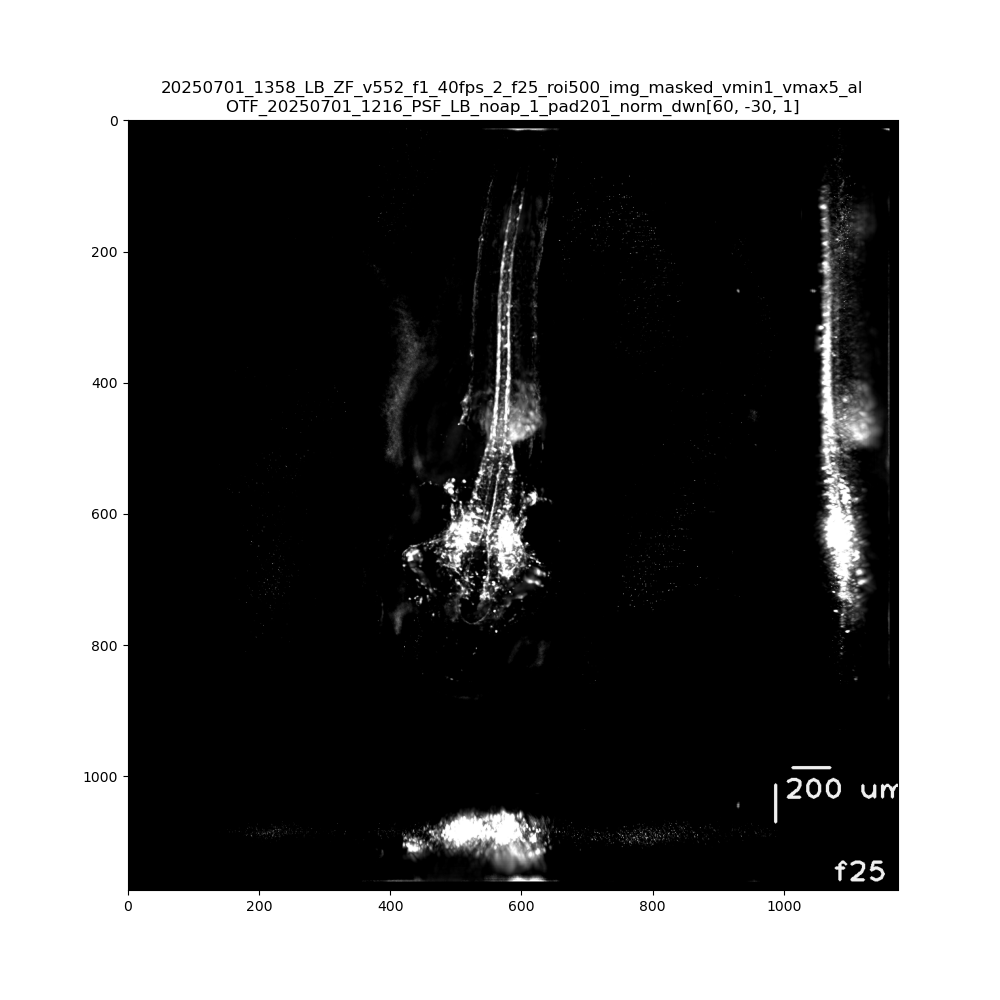

In [126]:
import video
importlib.reload(video)

from video import create_projection_image, array3d_to_video

frame = 0

vmin=1
vmax=5
absolute_limits=True
_zpos = zpos[kwargs["psf_downsample"][0]:kwargs["psf_downsample"][1]:kwargs["psf_downsample"][2]] if kwargs["psf_downsample"] is not None else zpos


fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(create_projection_image(objs[0], vmin=vmin, vmax=vmax, absolute_limits=absolute_limits, zpos = _zpos, scalebar=200, text = f"f{np.arange(*img_idx)[frame]}",),cmap = "gray")

title = f"f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{vmin}_vmax{vmax}{"_al" if absolute_limits else ""}"
deconv_title = f"deconv_f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{kwargs["vmin"]}_vmax{kwargs["vmax"]}{"_al" if kwargs["absolute_limits"] else ""}"
otf_name = f"OTF_{paths.psf_name}_pad{kwargs["xy_pad"]}{"_clip" if kwargs["OTF_clip"] else ""}{"_norm" if kwargs["OTF_normalize"] else ""}{f'_dwn{kwargs["psf_downsample"]}' if kwargs["psf_downsample"] is not None else ''}"

ax.set_title(paths.dataset_name+"_"+title +"\n"+otf_name)
os.mkdir(os.path.join(paths.pn_outrec,"testmip")) if not os.path.exists(os.path.join(paths.pn_outrec,"testmip")) else None
fig.savefig(os.path.join(paths.pn_outrec,"testmip",f"{title}_{otf_name}.png"))

deconv_title = f"deconv_f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{kwargs["vmin"]}_vmax{kwargs["vmax"]}{"_al" if kwargs["absolute_limits"] else ""}"
otf_name = f"OTF_{paths.psf_name}_pad{kwargs["xy_pad"]}{"_clip" if kwargs["OTF_clip"] else ""}{"_norm" if kwargs["OTF_normalize"] else ""}{f'_dwn{kwargs["psf_downsample"]}' if kwargs["psf_downsample"] is not None else ''}"


array3d_to_video(mips[0],  os.path.join(paths.pn_outrec,"testmip",f"{deconv_title}_{otf_name}.mp4")) # doesnt change the vmax in the vid. redo the deconvolution to update this one

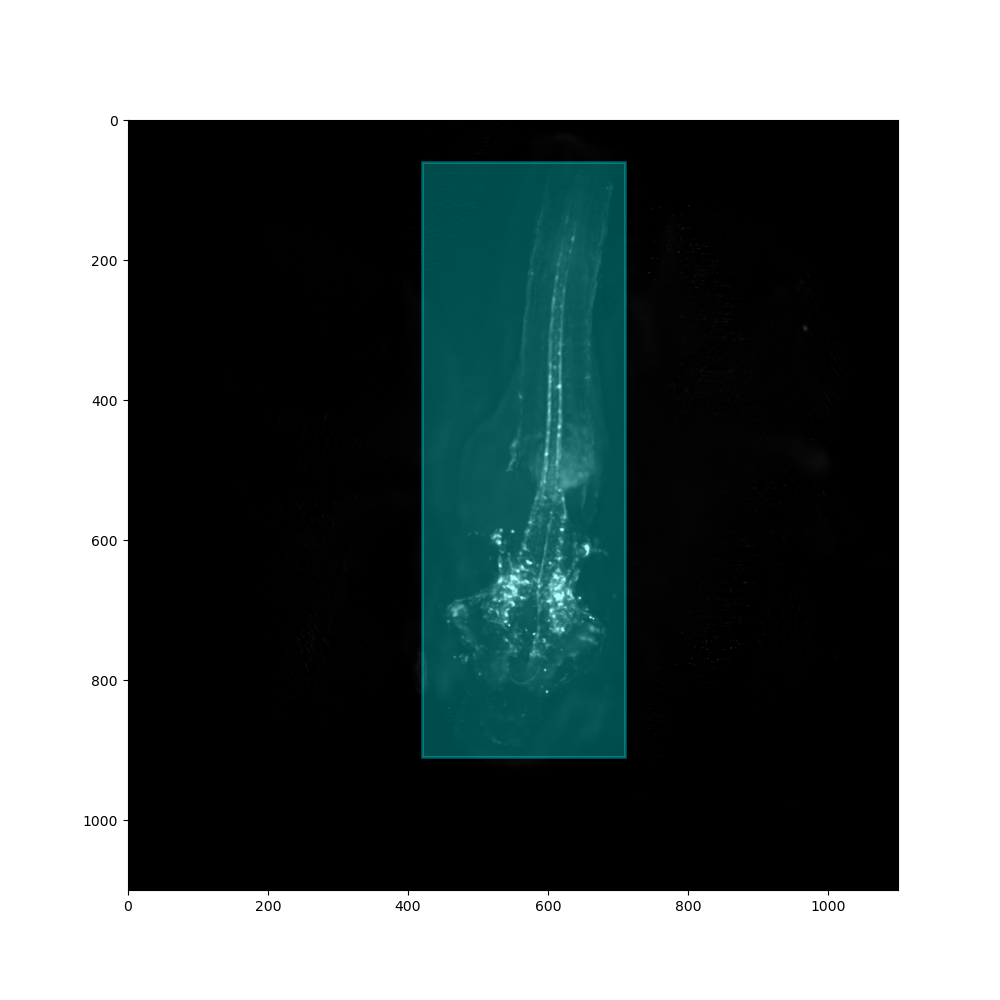

In [132]:
x1, y1 = 420, 60 #top left
x2, y2 = 710, 910 #bottom right

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(objs[0].max(axis=0), cmap = "gray", vmax=10)
rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="cyan", facecolor="cyan", alpha=0.3
    )
ax.add_patch(rect)
out_crop = (y1,y2,x1,x2)
kwargs["out_crop"] = out_crop

In [133]:
kwargs["vmax"] = 10
kwargs["transpose"]=True
kwargs

{'max_iter': 50,
 'xy_pad': 201,
 'roi_size': 550,
 'loss_threshold': 0,
 'reuse_prev_vol': False,
 'psf_downsample': [60, 205, 1],
 'OTF_normalize': True,
 'OTF_clip': False,
 'crop': array([   0, 2048,    0, 2048]),
 'img_subtract_bg': False,
 'img_mask': True,
 'fully_batched': False,
 'vmin': 0,
 'vmax': 10,
 'absolute_limits': True,
 'transpose': True,
 'out_crop': (60, 910, 420, 710)}

## Deconvolve the whole recording

In [134]:
import slurm
importlib.reload(slurm)
from slurm import PythonExecutorSLURM
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs_parallel
kwargs, save_fn, vid_fn = reconstruct_vols_from_imgs_parallel(paths,img_idx=(3020,3025,1),write_mip_video=True,**kwargs)
# print(save_fn,"\n",vid_fn)


Loading PSF, Calculating OTF


Calculating OTF: (downsampling PSF by 1):   0%|          | 0/145 [00:00<?, ?it/s]

Setting up I/O queues
Writing into new file: /home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/deconvolved_frames3020-3025.h5
GPU 0: Initializing Memory


GPU 0: Deconvolving image 3021/5:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 3022/5:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 3023/5:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 3024/5:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 3025/5:   0%|          | 0/50 [00:00<?, ?it/s]

Deconvolution finished in 00:01:47


In [136]:
email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='deconv'+paths.dataset_name, conda_env='lfm1',
                                     time="0-12:00", partition="pgpu", gres="gpu:4", cpus_per_task=16,mem='128G',ntasks=1,nodes=1,exclude="s-sc-pgpu03",
                                     cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')

In [137]:
job_id = slex.submit(reconstruct_vols_from_imgs_parallel, paths, **kwargs, verbose=2)
print(paths.dataset_name)

Submitted batch job 5522376

20250701_1358_LB_ZF_v552_f1_40fps_2


## Setup registration

In [3]:
ref_vol_idx=[0,10,1] #should have no movement
fn_raw_ref_vid = os.path.join(paths.pn_outrec, "ref_raw.mp4")


ref_vid_writer = AVWriter2(, fps=10, expected_indeces=range(*ref_vol_idx))
ref_reader = VolumeReader(paths.raw, "data", ref_vol_idx)
for i, frame in ref_reader:
    font, lineType = cv2.FONT_HERSHEY_PLAIN, text_size+1
        text_width, text_height = cv2.getTextSize(text, font, text_size, lineType)[0]
    frame =cv2.putText(frame, f"f{i}", 
                             org=10, 
                             fontFace=font,
                             fontScale=text_size, 
                             color = color,
                             thickness=lineType)   


In [ ]:
test_reg_idx=[100, 120] #ideally has movement

In [ ]:
result.deconvolution_params["OTF"]

In [4]:
import video
importlib.reload(video)
from video import recording_to_video
video_fn = recording_to_video(paths, fps=40, vmax=15, absolute_limits=True)
#it took 1:20:00

Creating video:   0%|          | 0/4020 [00:00<?, ?it/s]

In [6]:
import numpy as np
import cupy as cp
cp.array([1,0,1],dtype=bool)

array([ True, False,  True])

In [90]:

import video
importlib.reload(video)
import i_o
importlib.reload(i_o)
from video import recording_to_video, array3d_to_video
import time
start = time.time()
# video_fn = recording_to_video(paths, fps=40, vmax=20, absolute_limits=True)
print("it took", time.time()-start)

it took 2.384185791015625e-05
